# LSXPS x FINK

In [1]:
import pandas as pd
import numpy as np

from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time

import swifttools.ukssdc.data.SXPS as uds
import swifttools.ukssdc.query as uq
from swifttools.ukssdc import plotLightCurve

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')


from script.plot import get_ppix, plot_mwd, plot_mw_lc


### Download the LSXPS Catalog

In [2]:
sources_data = uds.getFullTable(table='sources',
                                returnData=True,
                                saveData=False,
                                silent=False,
                                verbose=True)


Uploading data to https://www.swift.ac.uk/API/main.php
Returned keys: dict_keys(['OK', 'URL', 'FILE', 'APIVersion'])
Checking returned data for required content.
Saving file `/tmp/tmp8y2u9ulq/LSXPS_Sources.csv`
Removing downloaded file /tmp/tmp8y2u9ulq/LSXPS_Sources.csv


### Load the cross-match data

The cross-match data have been performed with Spark between all the available ZTF data in the Fink database and the LSXPS catalog version of the 10 November 2022. 
The ZTF data are the database snapshot of the 10 November 2022. As of 10/11/2022, there are 107,017,121 alerts available.

The ZTF alerts have been associated with a sources from LSXPS using the Err90 column given the X-ray detection error box in arcsecond.

Cross-match algorithm:
* Take all ZTF data
* Remove duplicates objectId to get only the objects and not all the alerts
* Take all LSXPS data 
* Compute healpix_column for both ZTF and LSXPS data (NSIDE = 1024, pixel_size = 3.44 arcmin)
* Join both dataframe based on the healpix column
* Refine the associations by using the Err90 column
    * separation(ztf_coordinates, lsxps_coordinates) < Err90
* Return the associations

In [3]:
ztf_x_lsxps = pd.read_parquet("../data/crossmatch/ztf_x_lsxps.parquet")

nb_unique_object = len(np.unique(ztf_x_lsxps["objectId"]))

nb_unique_objects_in_Fink = 27965535

msg = """
---
Total: {} sources
Fraction of ZTF sources: {:.1f}%
Fraction of SWIFT X-ray sources: {:.1f}%
""".format(
    nb_unique_object,
    nb_unique_object/nb_unique_objects_in_Fink*100,
    nb_unique_object/len(sources_data)*100
)

print(msg)



---
Total: 25286 sources
Fraction of ZTF sources: 0.1%
Fraction of SWIFT X-ray sources: 8.9%



### Fink Classification

In [4]:
# Per alert

ztf_x_lsxps\
    .groupby('fink_class')\
    .count()\
    .sort_values('objectId', ascending=False)[['objectId']]


,objectId
fink_class,
Unknown,337764
QSO,204046
Seyfert_1,160674
BLLac,91964
CataclyV*,37933
...,...
ULX,1
Candidate_LensSystem,1
HH,1


In [5]:
# Per object

ztf_x_lsxps\
    .drop_duplicates("objectId")\
    .groupby('fink_class')\
    .count()\
    .sort_values('objectId', ascending=False)[['objectId']]


,objectId
fink_class,
Unknown,13114
QSO,3738
Seyfert_1,1654
Star,802
Solar System MPC,795
...,...
Region,1
Cepheid_Candidate,1
SNR,1


## Sky location

Crappy script to look at the sky distribution...

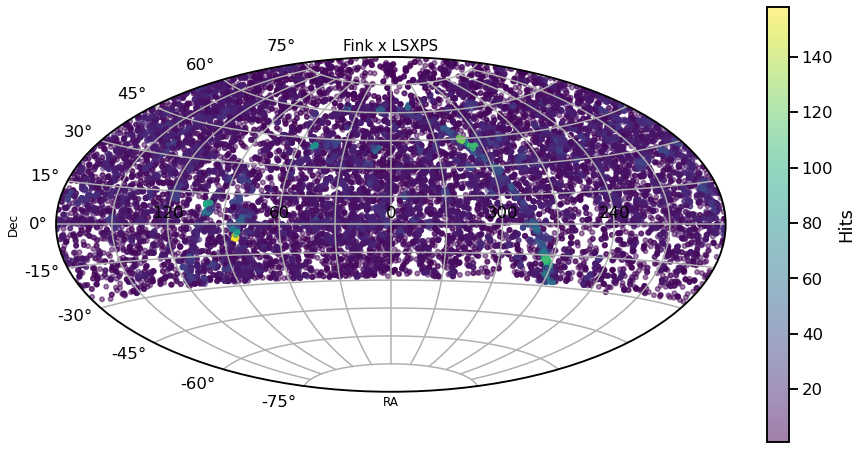

In [6]:
unique_ztf_sources = ztf_x_lsxps.drop_duplicates("objectId")

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='aitoff')

ppixs = get_ppix(unique_ztf_sources, 1024)
plot_mwd(
    fig,
    unique_ztf_sources['ra'].values,
    unique_ztf_sources['dec'].values,
    ppixs,
    ax=ax,
    title='Fink x LSXPS',
    cb_title='Hits',
    alpha=0.5,
    org=0
)


### Alerts Rate per day

In [7]:
ztf_x_lsxps["jd_day"] = ztf_x_lsxps["jd"].astype(int)
alert_per_day = ztf_x_lsxps.groupby("jd_day").count()

object_per_day = ztf_x_lsxps.groupby("jd_day").agg(
    nb_objects=("objectId", lambda x: len(np.unique(x)))
)

msg = """
Objects/Alerts Rate for LSXPS per day

* Alerts:
    Min : {}, Max : {},
    Mean : {:.1f} alerts/day ± {:.1f}

* Objects
    Min : {}, Max : {},
    Mean : {:.1f} objects/day ± {:.1f}
""".format(
    alert_per_day["objectId"].min(), alert_per_day["objectId"].max(),
    alert_per_day["objectId"].mean(), alert_per_day["objectId"].std(),
    object_per_day["nb_objects"].min(), object_per_day["nb_objects"].max(),
    object_per_day["nb_objects"].mean(), object_per_day["nb_objects"].std()
)

print(msg)



Objects/Alerts Rate for LSXPS per day

* Alerts:
    Min : 1, Max : 3495,
    Mean : 1321.4 alerts/day ± 702.2

* Objects
    Min : 1, Max : 2471,
    Mean : 919.6 objects/day ± 472.0



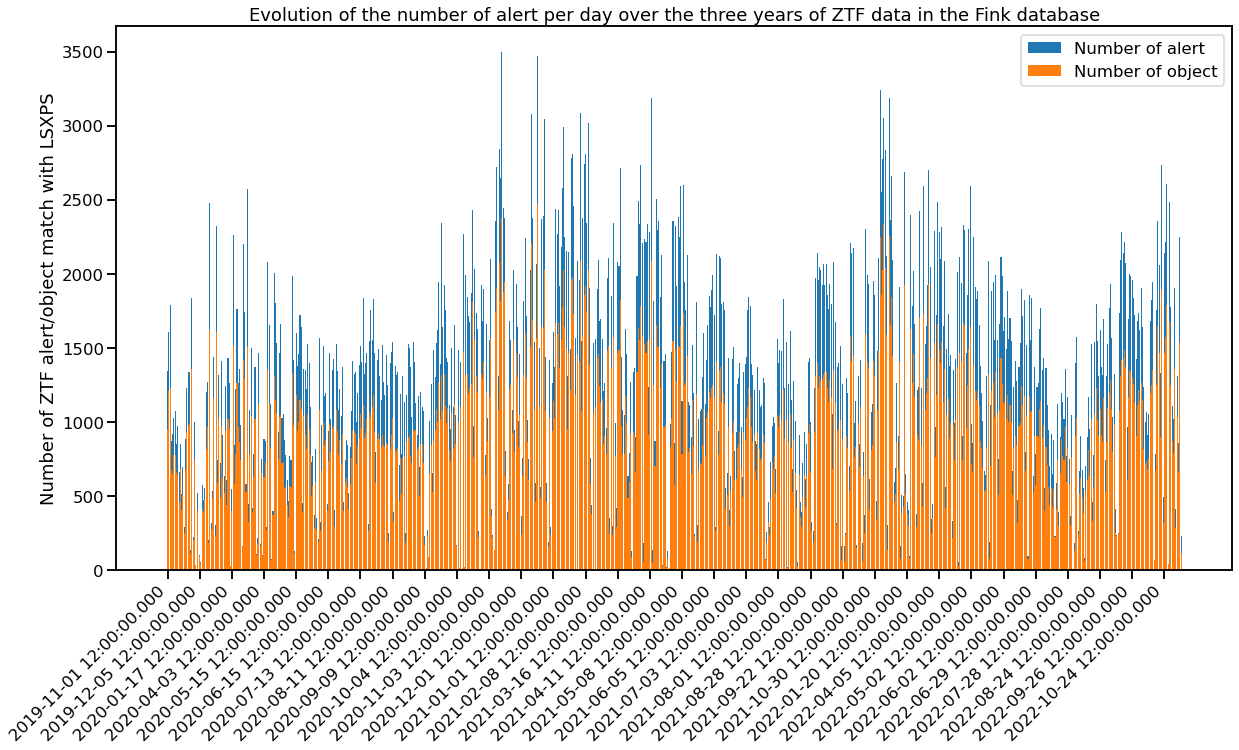

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.bar(
    np.array(Time(alert_per_day.reset_index()["jd_day"], format="jd").iso),
    alert_per_day["objectId"].values,
    label="Number of alert"
)
ax.bar(
    np.array(Time(object_per_day.reset_index()["jd_day"], format="jd").iso),
    object_per_day["nb_objects"].values,
    label="Number of object"
)
plt.draw()
plt.legend()
plt.ylabel("Number of ZTF alert/object match with LSXPS")
plt.title("Evolution of the number of alert per day over the three years of ZTF data in the Fink database")
ax.set_xticks(ax.get_xticks()[::25], ax.get_xticklabels()[
              ::25], rotation=45, ha='right')
plt.show()


### Number of alerts per objects in ZTF

In [9]:
ztf_nb_alerts = ztf_x_lsxps.sort_values("jd").groupby("objectId").agg(
    nb_alerts=("ra", len),
    obs_window=("jd", lambda x: list(x)[-1] - list(x)[0])
).sort_values("nb_alerts", ascending=False)


In [10]:
ztf_nb_alerts


,nb_alerts,obs_window
objectId,,
ZTF18abosglv,1210,1107.127627
ZTF18aauselm,1116,753.997176
ZTF18abgytsy,1085,1107.107106
ZTF18abjgkvd,1074,1107.006123
ZTF19aalbrmw,954,1107.010590
...,...,...
ZTF18aaifwpa,1,0.000000
ZTF20acvktlt,1,0.000000
ZTF20acvkicg,1,0.000000


In [11]:
msg = """
Number of alerts for each ZTF objects with a match in LSXPS

Min : {} alerts, Max : {} alerts
Mean : {:.1f} alerts ± {:.1f}

--------

Observations window for each object

Min : {} days, Max : {} days
Mean : {:.1f} days ± {:.1f}
""".format(
    ztf_nb_alerts["nb_alerts"].min(), ztf_nb_alerts["nb_alerts"].max(),
    ztf_nb_alerts["nb_alerts"].mean(), ztf_nb_alerts["nb_alerts"].std(),
    int(ztf_nb_alerts["obs_window"].min()), int(
        ztf_nb_alerts["obs_window"].max()),
    ztf_nb_alerts["obs_window"].mean(), ztf_nb_alerts["obs_window"].std()
)

print(msg)



Number of alerts for each ZTF objects with a match in LSXPS

Min : 1 alerts, Max : 1210 alerts
Mean : 41.2 alerts ± 81.4

--------

Observations window for each object

Min : 0 days, Max : 1107 days
Mean : 484.9 days ± 415.5



### MultiWavelength LightCurves

In [12]:
lsxps_match_ztf = ztf_x_lsxps.drop_duplicates("LSXPS_ID")

In [13]:
ztf_large_obs = lsxps_match_ztf[lsxps_match_ztf["objectId"].isin(
ztf_nb_alerts.sort_values("nb_alerts").tail(20).reset_index()["objectId"])]


-----------------------
https://fink-portal.org/ZTF18aauselm


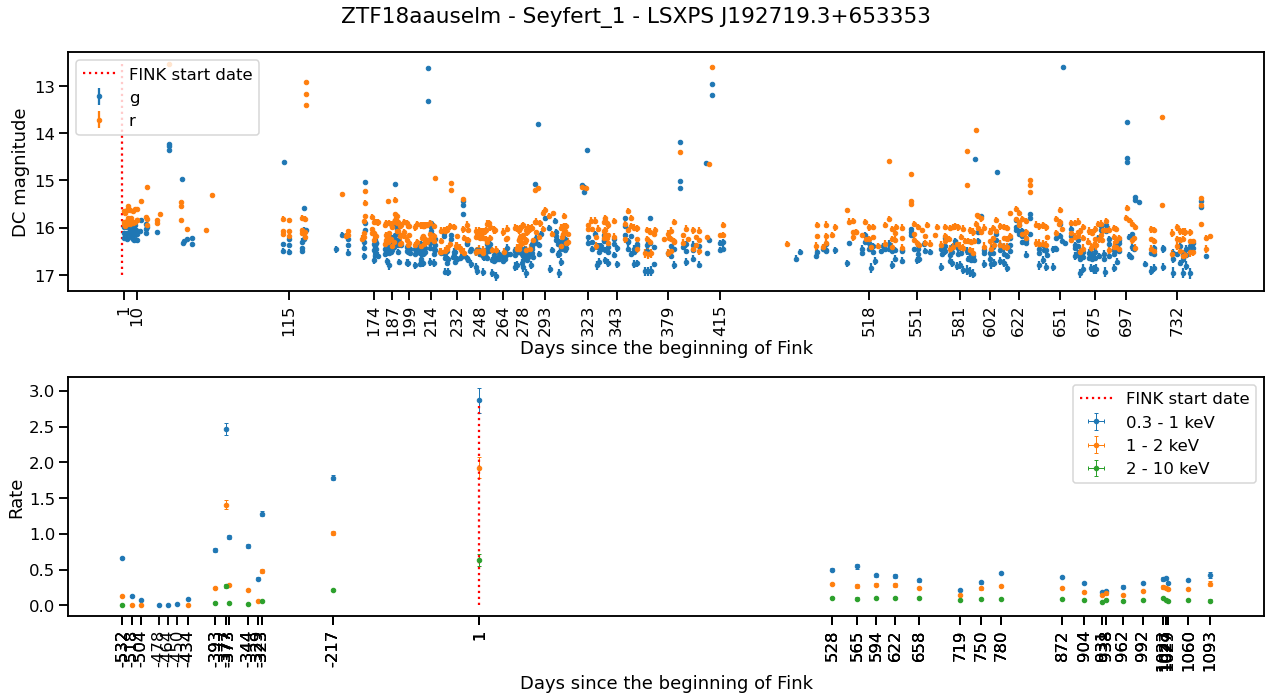


-----------------------
https://fink-portal.org/ZTF18abkicej


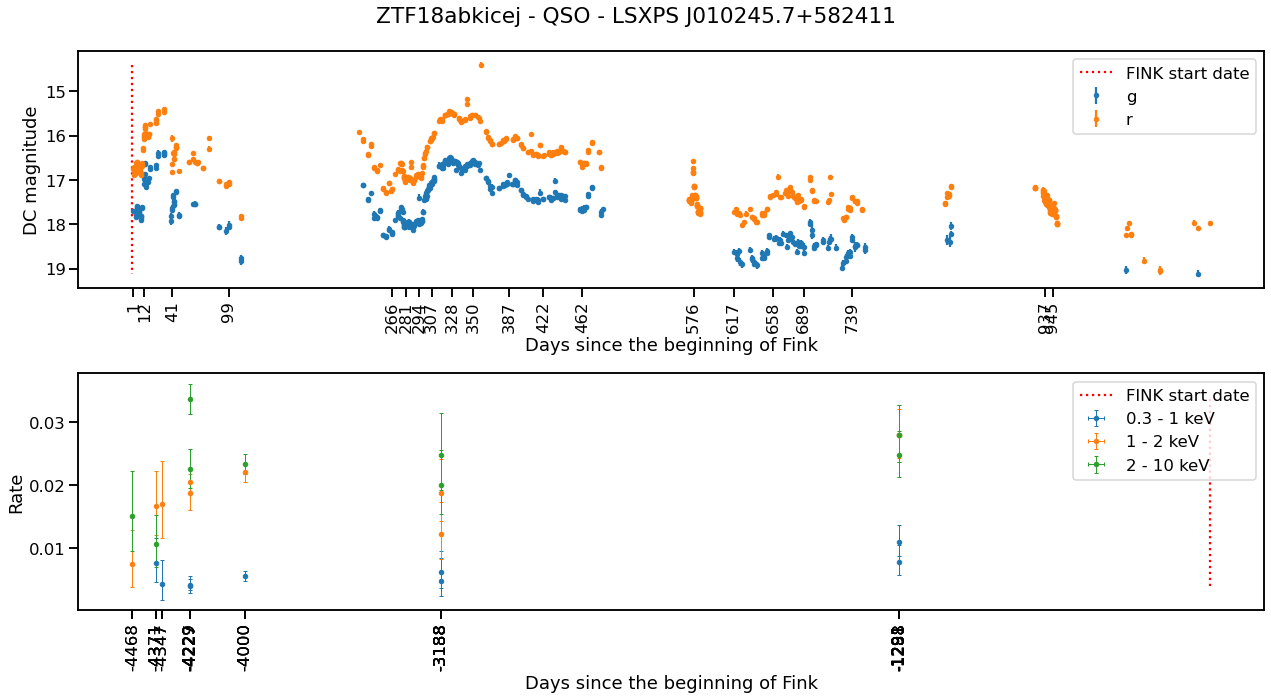


-----------------------
https://fink-portal.org/ZTF18abkhtlr


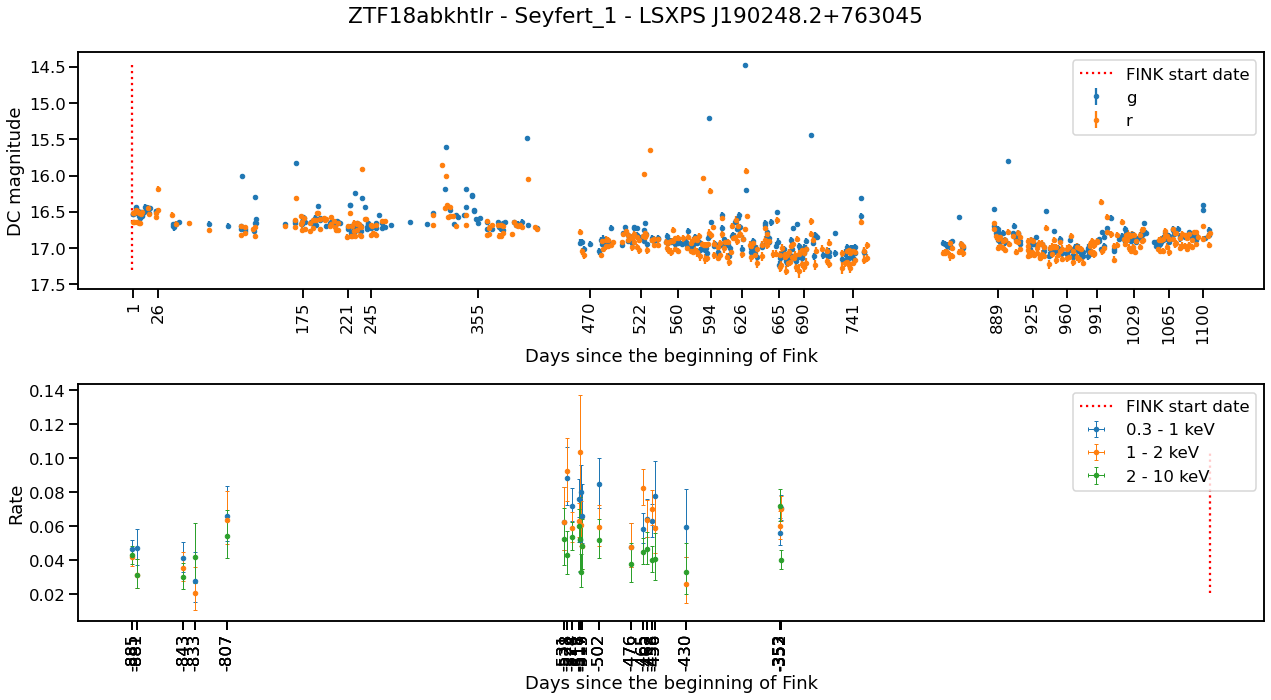


-----------------------
https://fink-portal.org/ZTF18abosglv


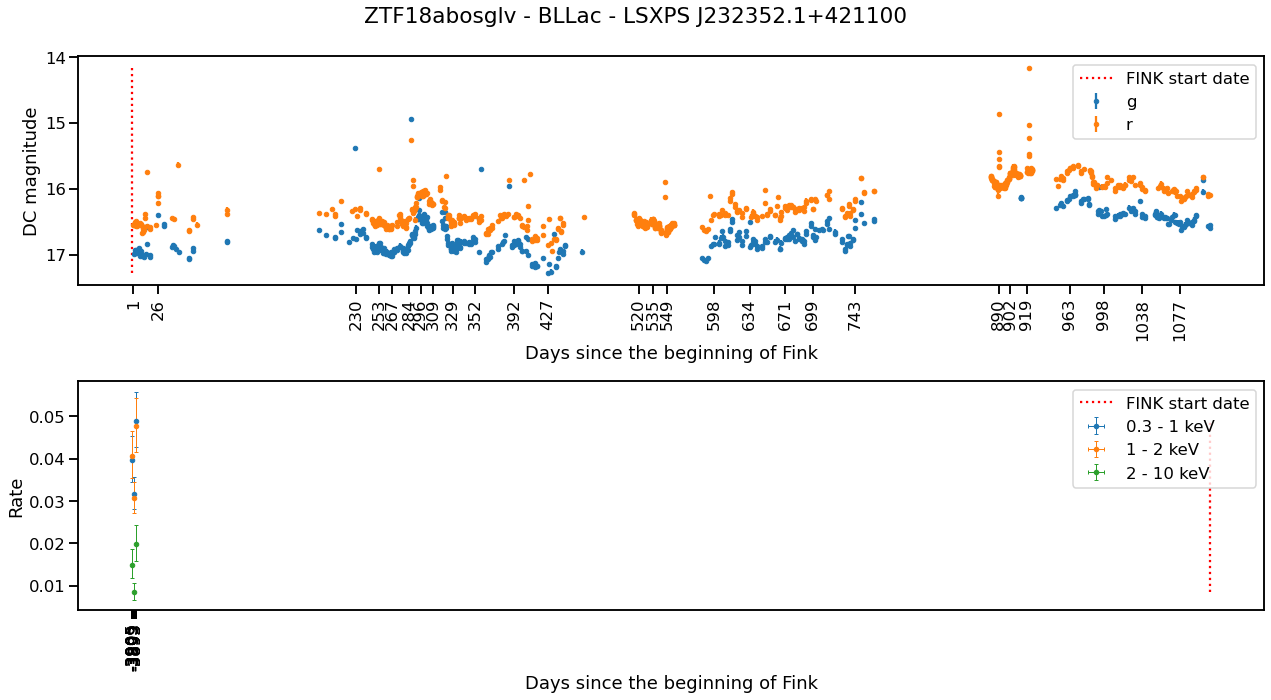


-----------------------
https://fink-portal.org/ZTF18abmacpq


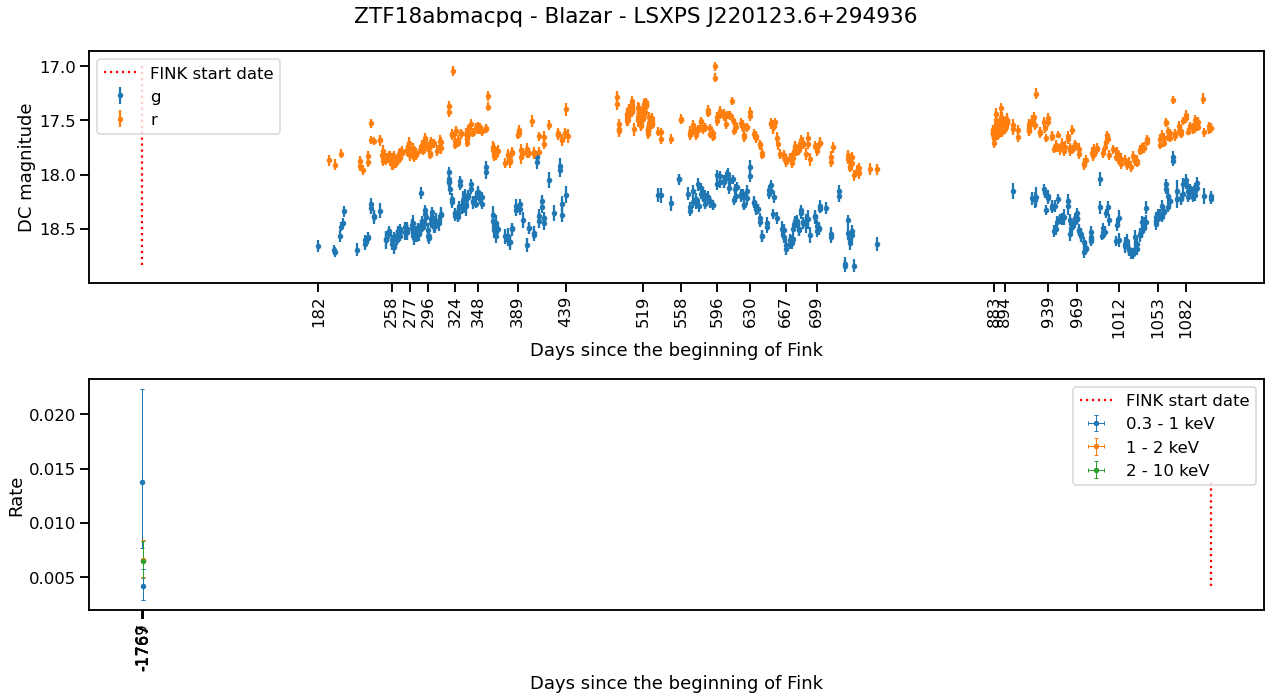


-----------------------
https://fink-portal.org/ZTF18aazvhcb


/home/roman/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


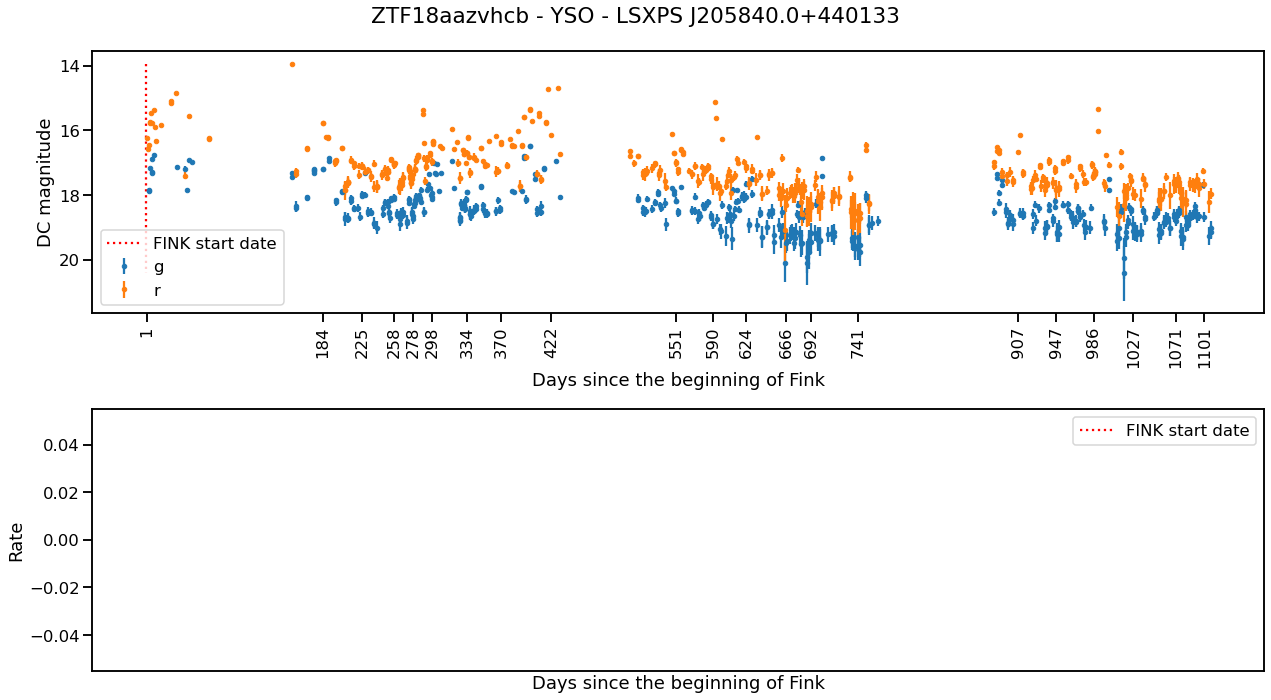


-----------------------
https://fink-portal.org/ZTF18abkxpln


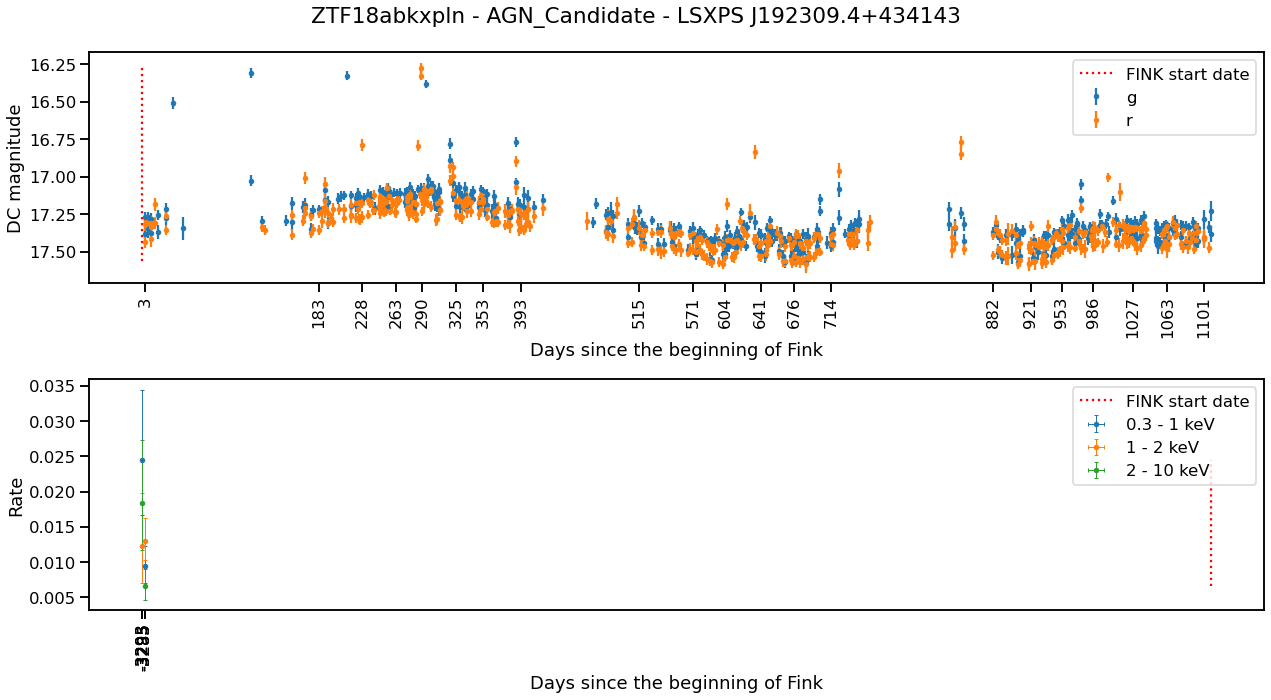


-----------------------
https://fink-portal.org/ZTF18aajucng


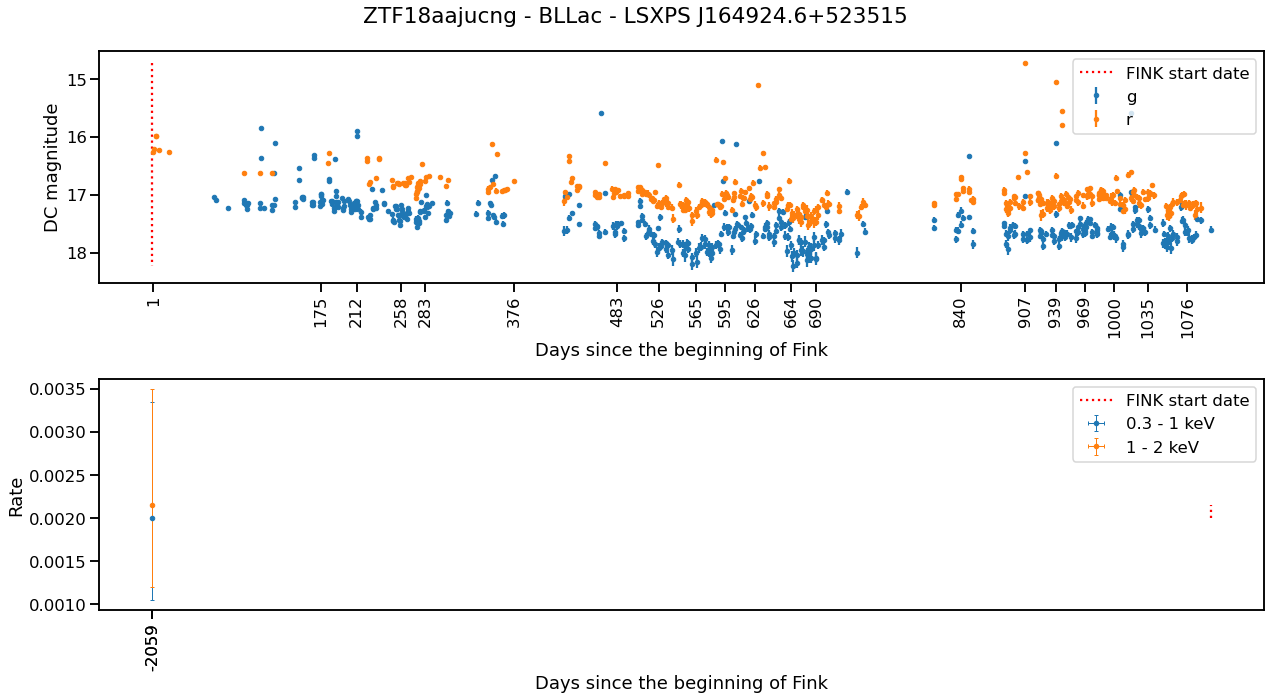


-----------------------
https://fink-portal.org/ZTF18abjgkvd


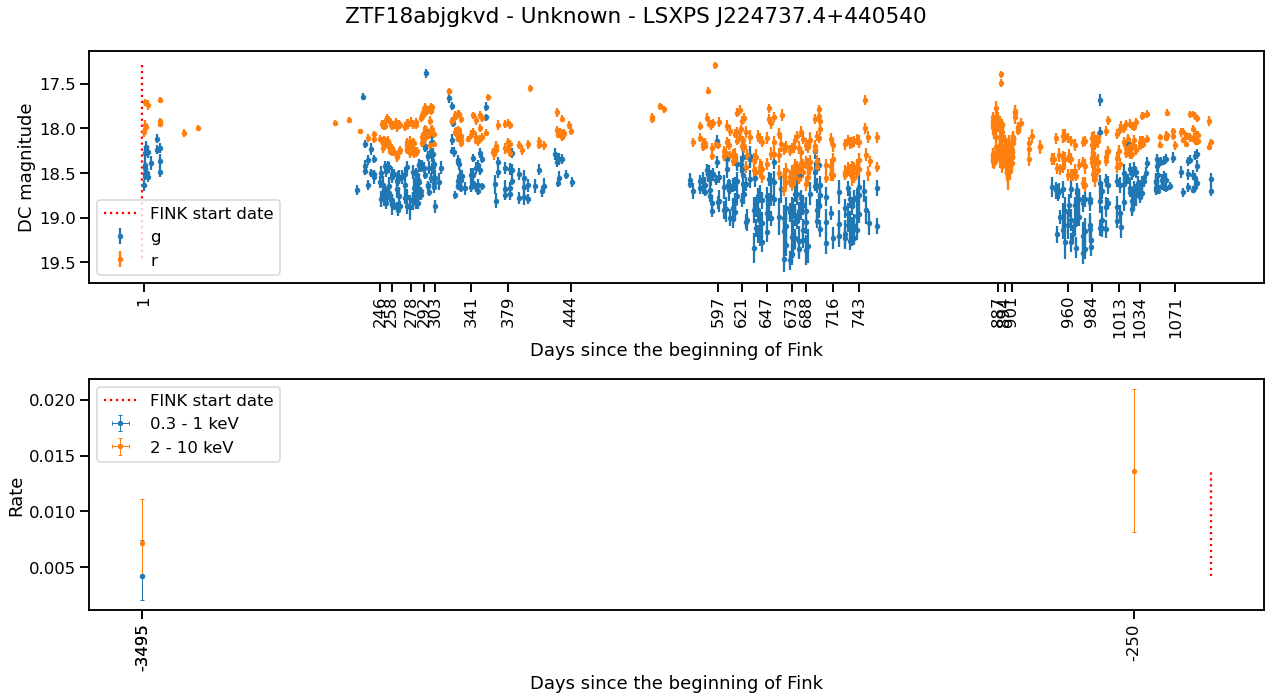


-----------------------
https://fink-portal.org/ZTF18acdwbev


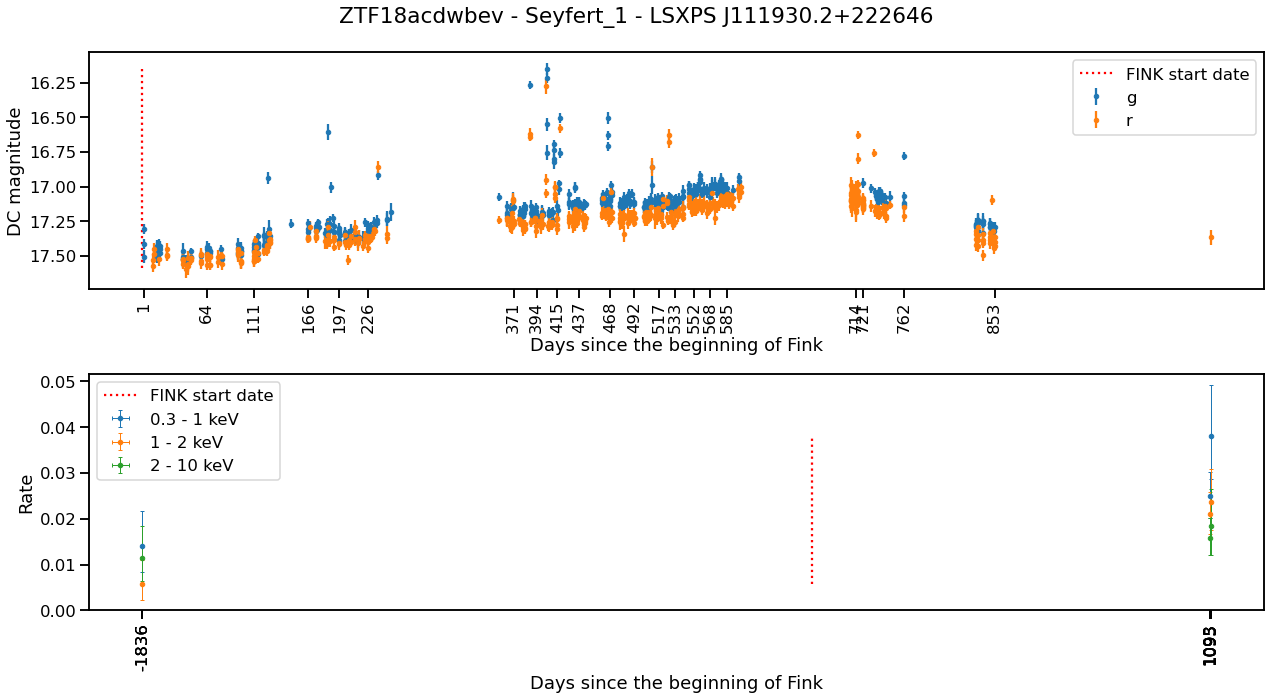


-----------------------
https://fink-portal.org/ZTF18aacgqfy


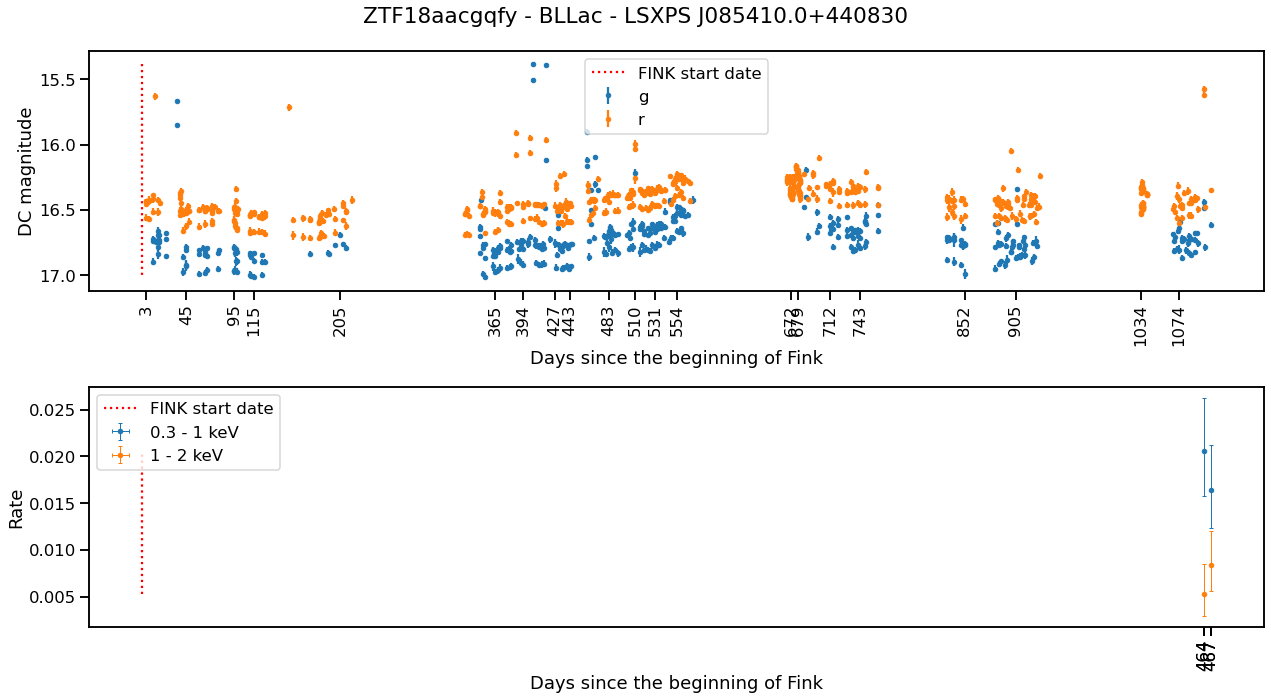


-----------------------
https://fink-portal.org/ZTF18abcqzxh


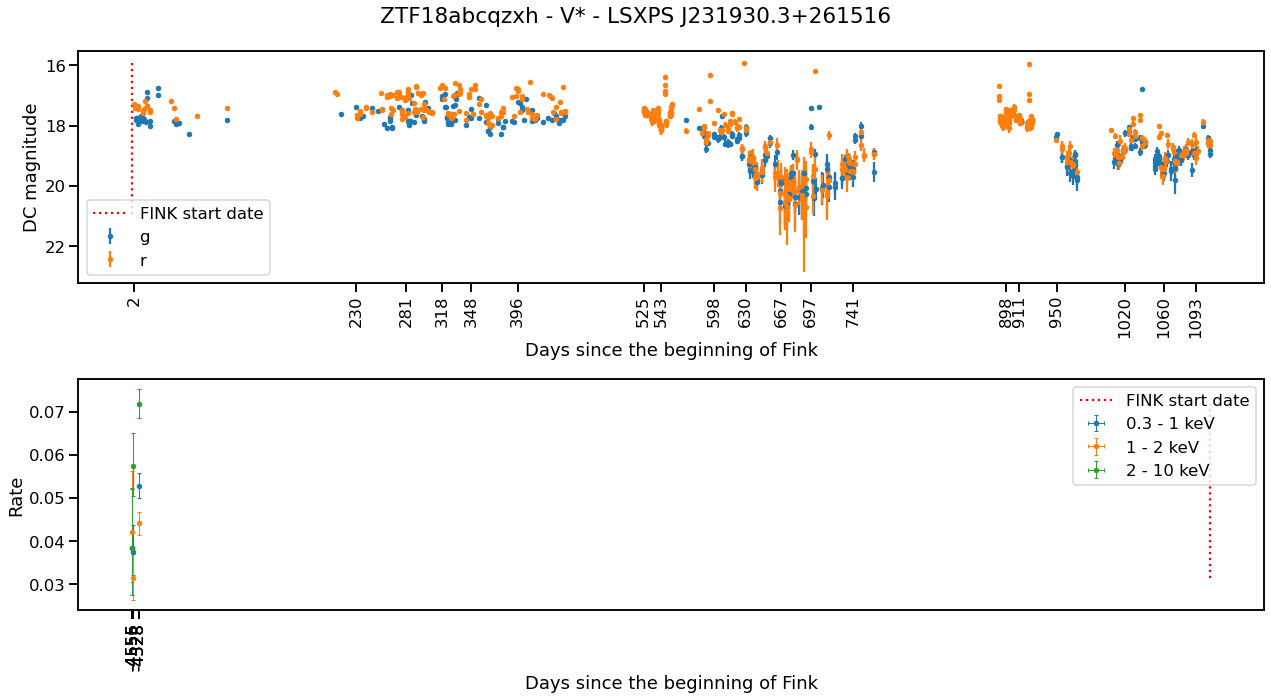


-----------------------
https://fink-portal.org/ZTF18abcdtlj


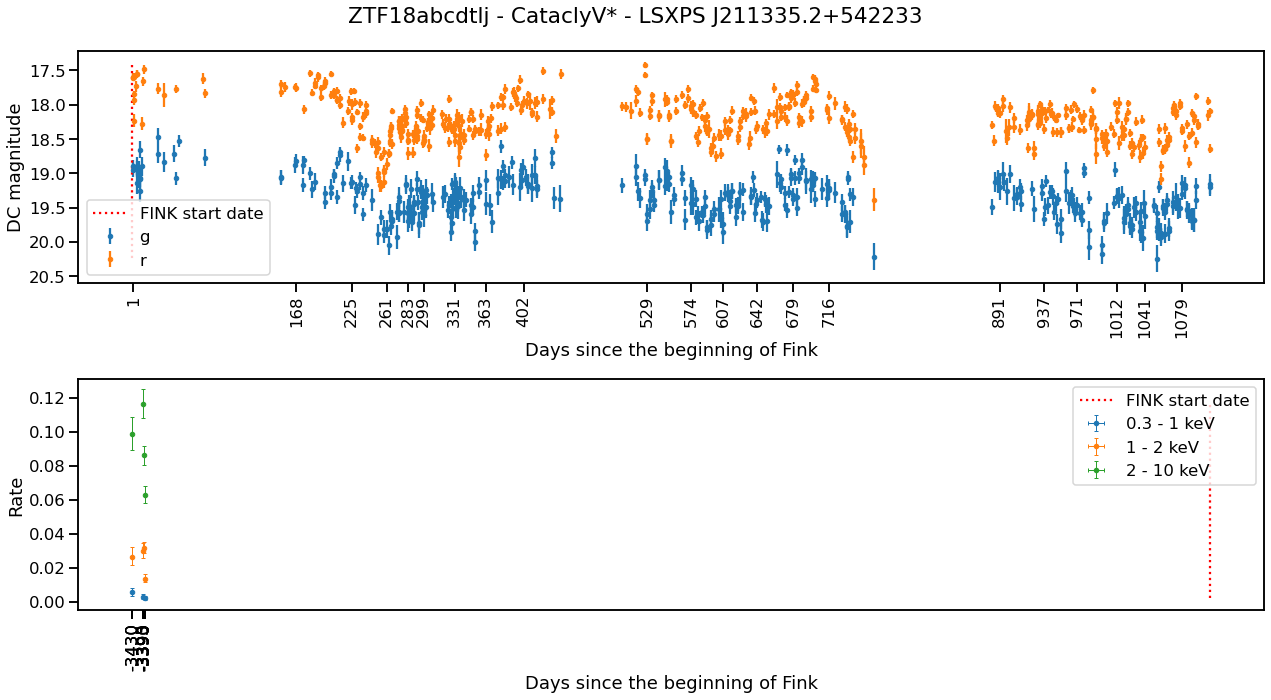


-----------------------
https://fink-portal.org/ZTF18abgytsy


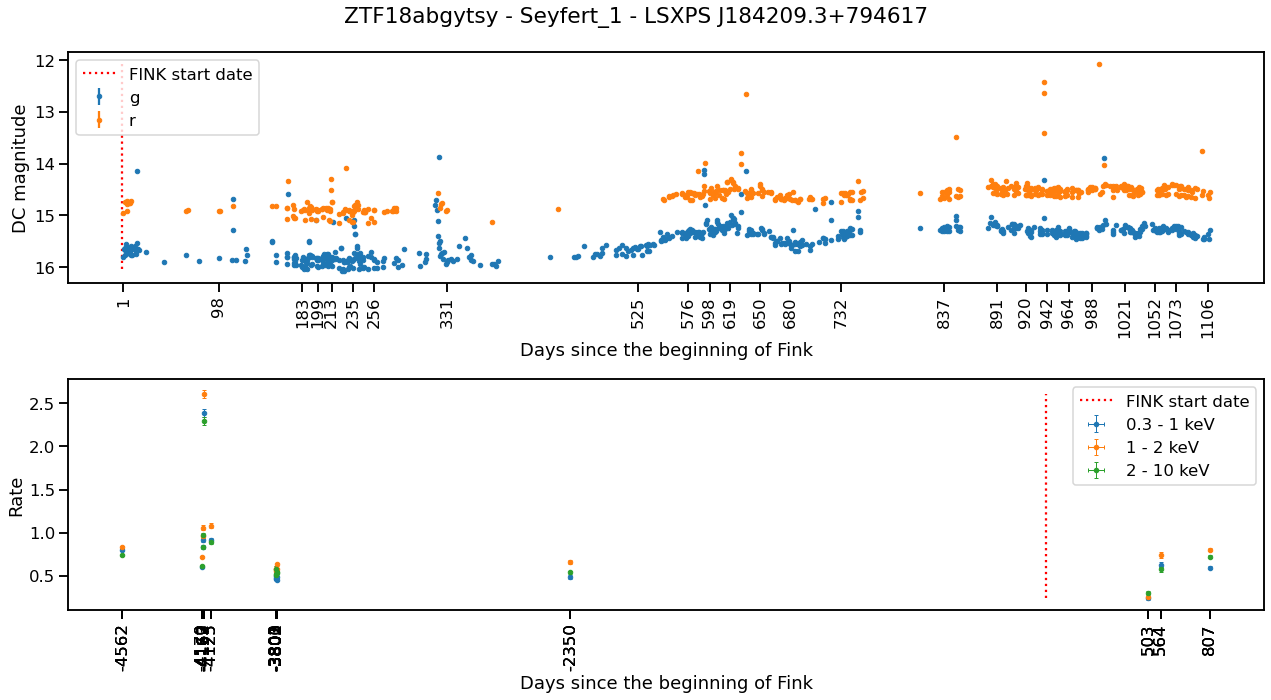


-----------------------
https://fink-portal.org/ZTF18abmodtn


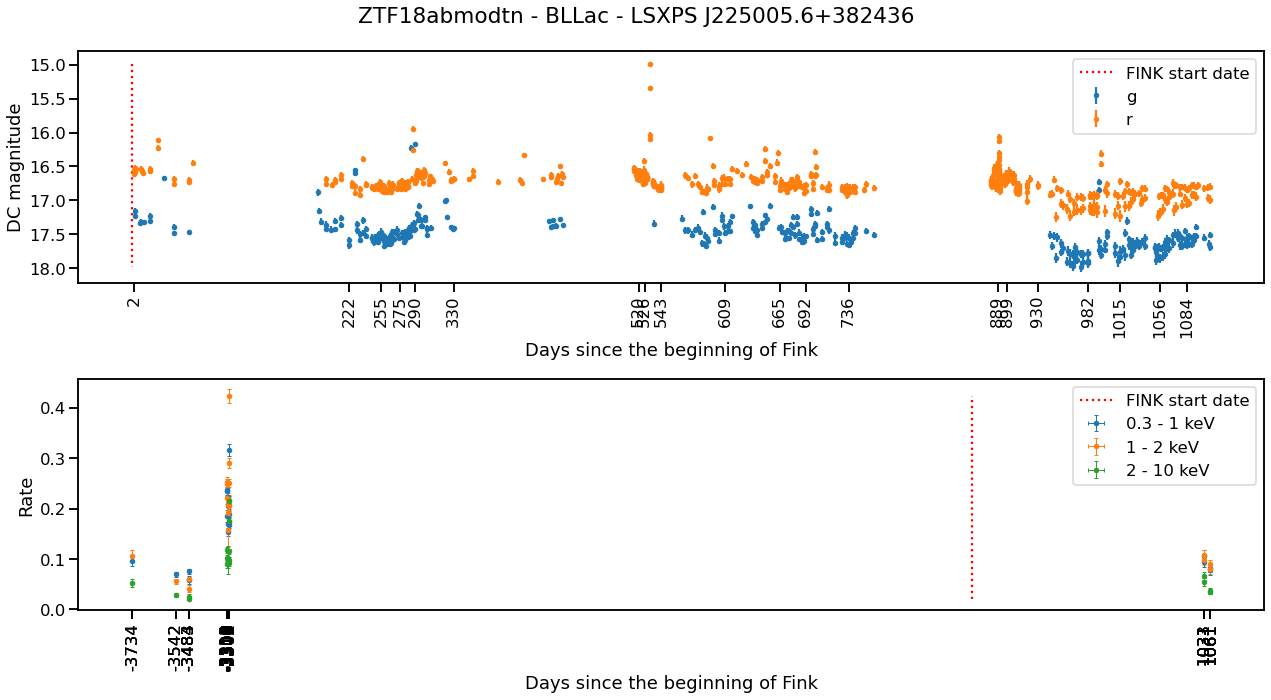


-----------------------
https://fink-portal.org/ZTF19abeyyro


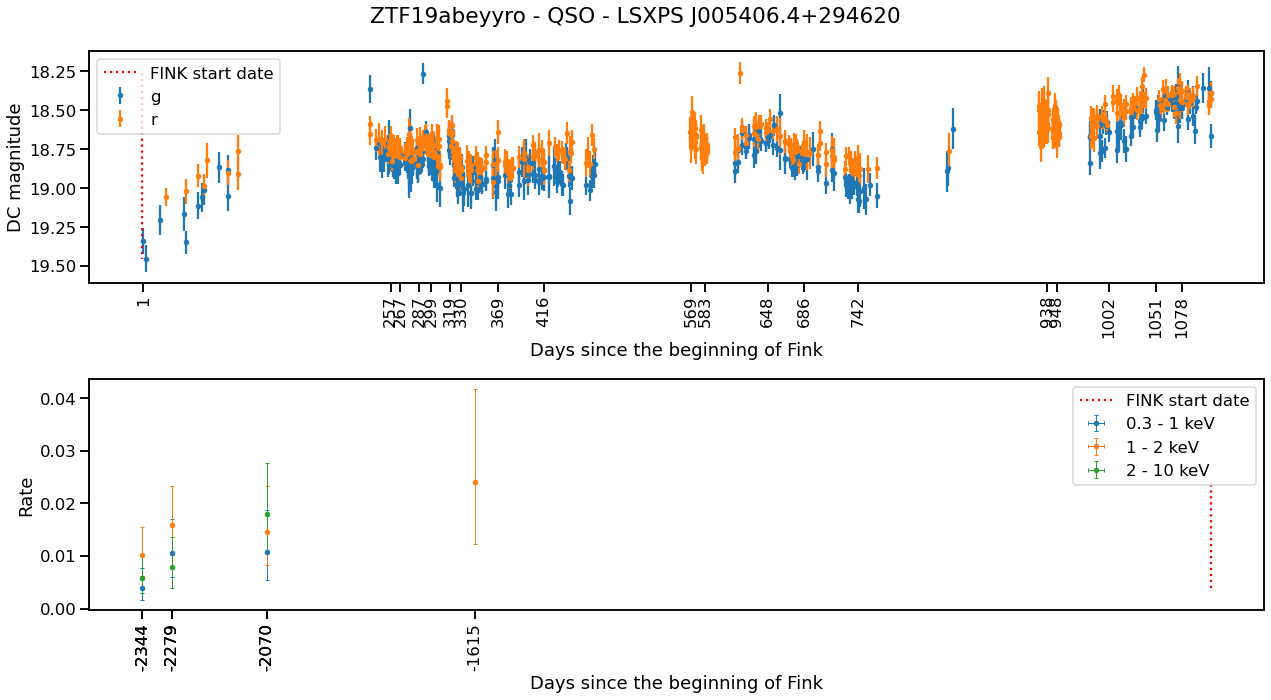


-----------------------
https://fink-portal.org/ZTF18aavvdip


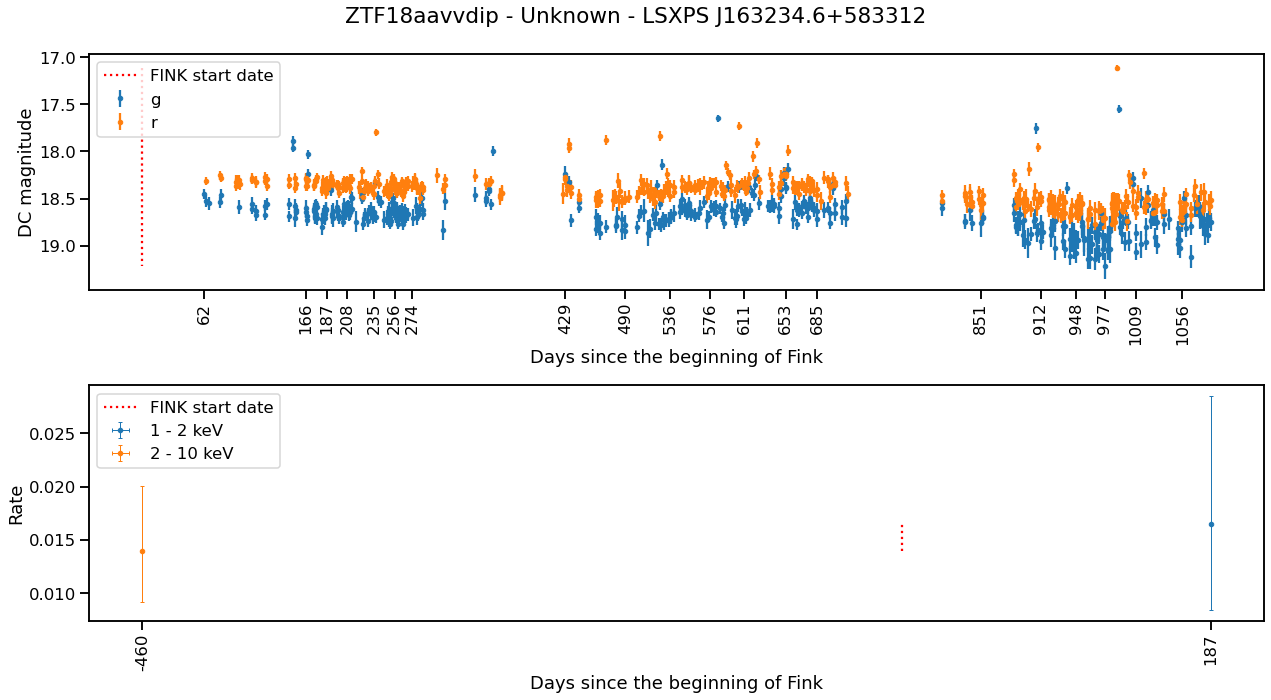


-----------------------
https://fink-portal.org/ZTF19aalbrmw


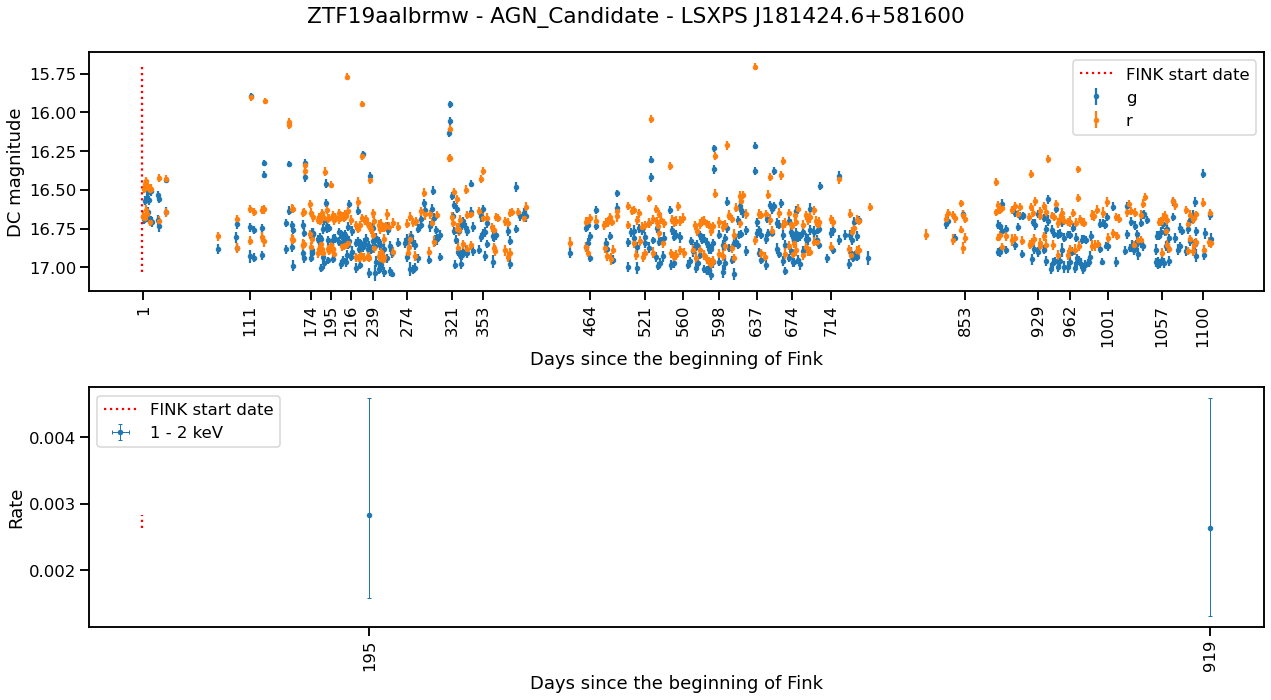

In [14]:
for objectId in ztf_large_obs["objectId"]:
    print()
    print("-----------------------")
    print('https://fink-portal.org/{}'.format(objectId))
    plot_mw_lc(ztf_x_lsxps, objectId)
